<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exercício-1---SMV-Regressor" data-toc-modified-id="Exercício-1---SMV-Regressor-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercício 1 - SMV Regressor</a></span><ul class="toc-item"><li><span><a href="#Aplicando-Cross-Validation" data-toc-modified-id="Aplicando-Cross-Validation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Aplicando Cross Validation</a></span></li><li><span><a href="#Comparando-diversos-modelos" data-toc-modified-id="Comparando-diversos-modelos-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparando diversos modelos</a></span></li><li><span><a href="#Aprimorando-Resultados-(GridSearchCV)" data-toc-modified-id="Aprimorando-Resultados-(GridSearchCV)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Aprimorando Resultados (GridSearchCV)</a></span></li></ul></li><li><span><a href="#Exercício-2---RandomizedSearchCV" data-toc-modified-id="Exercício-2---RandomizedSearchCV-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercício 2 - RandomizedSearchCV</a></span></li><li><span><a href="#Exercício-3---Pipeline" data-toc-modified-id="Exercício-3---Pipeline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercício 3 - Pipeline</a></span><ul class="toc-item"><li><span><a href="#Utilizando-SVM-Regressor" data-toc-modified-id="Utilizando-SVM-Regressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Utilizando SVM Regressor</a></span></li></ul></li><li><span><a href="#Exercício-4---Pipeline-Completo" data-toc-modified-id="Exercício-4---Pipeline-Completo-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exercício 4 - Pipeline Completo</a></span></li></ul></div>

## Exercício 1 - SMV Regressor

1 - Try a Support Vector Machine Regressor (```sklearn.svm.SVR```), with various hyperparameters such as ```kernel='linear'``` (with various values for C hyperparameters) or ```kernel='rbf'``` (with varioues values for the C and famma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

Antes de iniciar o exercício, é necessário preparar os dados.

In [1]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from future_encoders import OneHotEncoder, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.externals import joblib

In [2]:
# Realizando leitura do arquivo
df = pd.read_csv('datasets/housing/housing.csv')

# Separando os dados
df['income_cat'] = np.ceil(df['median_income'] / 1.5) # Limitando valores
df['income_cat'].where(df['income_cat'] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=42)

# Criando coluna adicional
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# Eliminando a coluna
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
target = 'median_house_value'
y_train, y_test = strat_train_set[target], strat_test_set[target]
X_train, X_test = strat_train_set.drop(target, axis=1), strat_test_set.drop(target, axis=1)

In [3]:
# Criando classe própria para combinação de atributos e utilização futura em Pipeline
indice_rooms, indice_bedrooms, indice_pop, indice_household = 3, 4, 5, 6

class CombinedAttr(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=False):
        self.add_bedrooms_per_room = add_bedrooms_per_room # Define uma combinação extra
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, indice_rooms] / X[:, indice_household]
        population_per_household = X[:, indice_pop] / X[:, indice_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, indice_bedrooms] / X[:, indice_bedrooms]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [4]:
# Preparando Pipeline
num_attribs = list(X_train.drop('ocean_proximity', axis=1))
cat_attribs = ['ocean_proximity']

# Definindo Pipeline numérico
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttr()),
    ('std_scaler', StandardScaler())
])

# Definindo Pipeline categórico
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder())
])

# Definindo Pipeline COMPLETO
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

# Dados preparados
X_train_prepared = full_pipeline.fit_transform(X_train)

In [5]:
# Criando Regressor SVM
svm_reg = SVR()
svm_reg.fit(X_train_prepared, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [6]:
# Realizando alguns testes rápidos no dataset original
some_data = df.iloc[:5]
some_labels = df['median_house_value'].iloc[:5]

# Aplicando pipeline
some_data_prepared = full_pipeline.transform(some_data)

# Verificando resultados
predictions = svm_reg.predict(some_data_prepared)
print(f'Predictions: {predictions}')
print(f'Target: {some_labels.values}')

Predictions: [180233.37514606 180107.16200717 180153.76651084 179877.60124421
 179538.01852982]
Target: [452600. 358500. 352100. 341300. 342200.]


Algo está muito errado...

In [7]:
# Testando com Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

# Realizando alguns testes rápidos no dataset original
some_data = df.iloc[:5]
some_labels = df['median_house_value'].iloc[:5]

# Aplicando pipeline
some_data_prepared = full_pipeline.transform(some_data)

# Verificando resultados
predictions = lin_reg.predict(some_data_prepared)
print(f'Predictions: {predictions}')
print(f'Target: {some_labels.values}')

Predictions: [407634.32088365 423201.8383078  381117.86461068 320715.50011369
 257604.52845538]
Target: [452600. 358500. 352100. 341300. 342200.]


    Realmente o SVR performou MUITO MAL. Vamos medir sua acurácia.

In [8]:
# Realizando predições com o cjto de treinamento
predictions = svm_reg.predict(X_train_prepared)

# Calculando erro
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

118574.40937899028

    Absurdamente alto. Vamos comparar com o treinamento realizado através da Regressão Linear

In [9]:
# Erro quadrático médio com Linear Regression
predictions = lin_reg.predict(X_train_prepared)
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68911.7605423384

### Aplicando Cross Validation

In [10]:
# Verificando se a cross validation melhora a situação do SVR
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_reg, X_train_prepared, y_train,
                        scoring='neg_mean_squared_error', cv=10)
svm_scores = np.sqrt(-scores)

Explicação do por que utilizar ```neg_mean_squared_error``` e não ```mean_squared_error```:

*WARNING*: C:\Users\thiagoPanini\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.

In [11]:
# Verificando scores através de uma função
def display_scores(scores):
    print(f'Scores: {scores}\n')
    print(f'Média: {scores.mean()}')
    print(f'Desv Pad: {scores.std()}')

display_scores(svm_scores)

Scores: [111394.72935104 119546.16936454 116972.32667654 120457.8919817
 117617.03814114 122308.34704619 117634.99268649 121470.90475521
 120355.93674124 118020.53525862]

Média: 118577.88720026996
Desv Pad: 2936.2873357509266


In [12]:
# Comparando com o modelo de Regressão Linear
scores = cross_val_score(lin_reg, X_train_prepared, y_train,
                        scoring='neg_mean_squared_error', cv=10)
lin_reg_scores = np.sqrt(-scores)

display_scores(lin_reg_scores)

Scores: [67461.9308165  67232.2484863  68224.22888082 74716.58955656
 68420.26897488 71610.91469695 65201.58349349 68686.9304607
 72262.5140762  68112.28697795]

Média: 69192.94964203317
Desv Pad: 2674.144726597017


### Comparando diversos modelos

In [13]:
# Definindo pipeline para preparação e treinamento de dados
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Definindo função para treinamento em massa
def linear_training(X_train, y_train):

    model_comparison = {
        'algoritmo': ['linear_regression', 'svr_regressor', 'tree_regressor', 'forest_regressir'],
        'folds_cv': [5, 5, 5, 5],
        'score_medio': [],
        'desv_pad': []
    }
    
    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    scores = cross_val_score(lin_reg, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=5)
    lin_reg_scores = np.sqrt(-scores)
    print('--- Scores for Linear Regression ---\n')
    display_scores(lin_reg_scores)
    print()
    model_comparison['score_medio'].append(lin_reg_scores.mean())
    model_comparison['desv_pad'].append(lin_reg_scores.std())
    
    # SVR
    svm_reg = SVR()
    svm_reg.fit(X_train, y_train)
    scores = cross_val_score(svm_reg, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=5)
    svm_reg_scores = np.sqrt(-scores)
    print('--- Scores for SVR Regression ---\n')
    display_scores(svm_reg_scores)
    print()
    model_comparison['score_medio'].append(svm_reg_scores.mean())
    model_comparison['desv_pad'].append(svm_reg_scores.std())
    
    # Decision Trees Regressor
    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(X_train, y_train)
    scores = cross_val_score(tree_reg, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=5)
    tree_reg_scores = np.sqrt(-scores)
    print('--- Scores for Decision Tree Regressor ---\n')
    display_scores(tree_reg_scores)
    print()
    model_comparison['score_medio'].append(tree_reg_scores.mean())
    model_comparison['desv_pad'].append(tree_reg_scores.std())
    
    # Random Forest
    forest_reg = RandomForestRegressor()
    forest_reg.fit(X_train, y_train)
    scores = cross_val_score(forest_reg, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=5)
    forest_reg_scores = np.sqrt(-scores)
    print('--- Scores for Random Forest Regressor ---\n')
    display_scores(forest_reg_scores)
    print()
    model_comparison['score_medio'].append(forest_reg_scores.mean())
    model_comparison['desv_pad'].append(forest_reg_scores.std())
    
    # Transformando resultados em um DataFrame
    return pd.DataFrame(model_comparison)

In [14]:
# Chamando função
model_comparison = linear_training(X_train_prepared, y_train)
model_comparison

--- Scores for Linear Regression ---

Scores: [67372.33386161 71377.12012377 70035.63165052 66964.20283004
 70278.43771076]

Média: 69205.54523533875
Desv Pad: 1728.5924294123142

--- Scores for SVR Regression ---

Scores: [115479.88496329 118673.75282394 120053.52353855 119622.23038932
 119298.10030231]

Média: 118625.49840348284
Desv Pad: 1635.9912075856812

--- Scores for Decision Tree Regressor ---

Scores: [68703.9061132  69485.1756656  74476.37100589 70696.76386639
 74326.88731705]

Média: 71537.8207936268
Desv Pad: 2423.459123420775

--- Scores for Random Forest Regressor ---

Scores: [51546.52516283 53501.81727196 55364.91736532 51594.9257692
 54574.31882794]

Média: 53316.50087945089
Desv Pad: 1543.314171133218



,algoritmo,desv_pad,folds_cv,score_medio
0,linear_regression,1728.592429,5,69205.545235
1,svr_regressor,1635.991208,5,118625.498403
2,tree_regressor,2423.459123,5,71537.820794
3,forest_regressir,1543.314171,5,53316.500879


### Aprimorando Resultados (GridSearchCV)

Para procurar a disponibilidade dos parâmetros de cada modelo, basta acessar os métodos ```estimator.get_params().keys()```.

In [15]:
# Buscando parâmtros possíveis
svm_reg.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [16]:
# Já o modelo de Regressão Linear...
lin_reg.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [17]:
# Definindo parâmetros
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100.]}, #, 300., 1000., 3000., 10000., 30000.0]}, demora muito
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30.], #, 100., 300., 1000.0], demora muito 
         'gamma': [0.01, 0.03, 0.1]}, #, 0.3, 1.0, 3.0]}, demora muito
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  8.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0], 'gamma': [0.01, 0.03, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [18]:
# Verificando scores retornados pelo grid
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

72038.33406140901

Um resultado muito mais interessante do que o anterior, porém ainda longe do encontrado pelo ```RandomForestRegressor()```. Vamos verificar a melhor combinação de hyperparâmetros encontrada.

In [19]:
# Melhor combinação
grid_search.best_params_

{'C': 100.0, 'kernel': 'linear'}

Aparentemente, quanto maior o valor do hiperparâmetro ```C```, melhor o resultado do modelo. Uma ideia é executar novamente o ```GridSearchCV```, passando números mais elevados para este hiperparâmetro e retirando os números menores.

## Exercício 2 - RandomizedSearchCV

2 - Try replacing ```GridSearchCV``` with ```RandomizedSearchCV```.

In [1]:
from scipy.stats import randint as sp_randint

In [9]:
sp_randint(1, 11)

In [20]:
# Realizando nova procura pelos melhores hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Detalhe: 'gamma' é ignorado quando o kernel = 'linear'
param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(50000, 200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error',
                               verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 10.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000237DD1EF080>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000237DD1EFE48>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [21]:
# Avaliando resultados com 5-fold cross validation
negative_mse = rnd_search.best_score_
rmse= np.sqrt(-negative_mse)
rmse

54534.48696447714

Agora sim! O modelo está competitivo! Ainda acredito que este erro é relativamente elevado, entretanto está muito melhor que nos primeiros testes. Vamos verificar qual combinação levou a este resultado.

In [22]:
# Verificando combinações de hiperparâmetros
rnd_search.best_params_

{'C': 192854.2631223385, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

Curioso que agora o kernel selecionado foi o ```rbf```. No geral, ```RandomizedSearchCV``` tende a encontrar melhores combinações de hiperparâmetros em um mesmo intervalo de tempo. Vamos entender os métodos do ```SciPy``` utilizados: ```reciprocal()``` e ```expon()```.

Documentação do módulo _stats_ do _SciPy_: https://docs.scipy.org/doc/scipy/reference/stats.html 

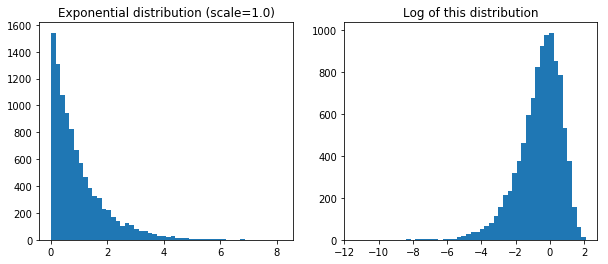

In [23]:
# Visualizando atribuições ao hiperparâmetro 'gamma' através do 'expon()'
import matplotlib.pyplot as plt
%matplotlib inline

expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

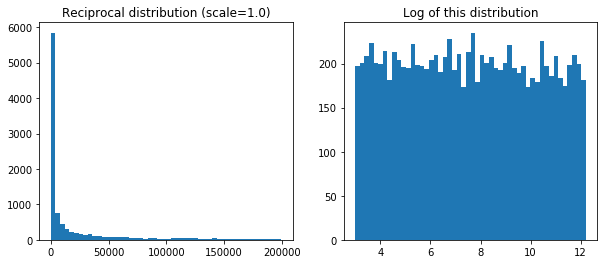

In [24]:
# Visualizando atribuições ao hiperparâmetro 'C' através do 'reciprocal()'
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

A distribuição recíproca (```reciprocal()```) é extremamente útil quando não se tem ideia de qual escala os hiperparâmetros devem estar. Por outro lado, a distribuição exponencial é mais adequado quando se tem uma pequena ideia sobre tais escalas.

In [25]:
# Criando com os demais algorítimos em um pipeline
def model_train(df_prepared, df_labels, 
                lin_reg=False, svm_reg=False, tree_reg=False, forest_reg=False):
    """
    Função que recebe dados de entrada e um algorítimo selecionado para realizar o treinamento completo
    """
    # Verificando o modelo escolhido
    if lin_reg:
        model = LinearRegression()
        desc = 'Linear Regression'
    elif svm_reg:
        model = SVR()
        desc = 'SVM'
    elif tree_reg:
        model = DecisionTreeRegressor()
        desc = 'Decision Tree Regressor'
    elif forest_reg:
        model = RandomForestRegressor()
        desc = 'Random Forest Regressor'
    else:
        print('Nenhum modelo selecionado.')
        return
    
    # Treinando e computando erro
    model.fit(df_prepared, df_labels)
    model_predictions = model.predict(df_prepared)
    model_mse = mean_squared_error(df_labels, model_predictions)
    model_rmse = np.sqrt(model_mse)
    print(f'Erro Médio Quadrádico para {desc}: {model_rmse:.2f}')

In [26]:
model_train(X_train_prepared, y_train, lin_reg=True)
model_train(X_train_prepared, y_train, svm_reg=True)
model_train(X_train_prepared, y_train, tree_reg=True)
model_train(X_train_prepared, y_train, forest_reg=True)

Erro Médio Quadrádico para Linear Regression: 68911.76
Erro Médio Quadrádico para SVM: 118574.41
Erro Médio Quadrádico para Decision Tree Regressor: 0.00
Erro Médio Quadrádico para Random Forest Regressor: 22081.84


## Exercício 3 - Pipeline

3 - Try adding a transformer in the preparation pipeline to select only thre most important attributes

In [27]:
# Realizando treinamento com forest_reg
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4, 5]}
]

forest_reg = RandomForestRegressor()
grid_search_forest = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 10]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
# Resultados
results = grid_search_forest.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

65768.3311211548 {'max_features': 1, 'n_estimators': 3}
58463.9992497956 {'max_features': 1, 'n_estimators': 10}
57012.71223131422 {'max_features': 1, 'n_estimators': 30}
65246.13219308834 {'max_features': 2, 'n_estimators': 3}
58370.000974677925 {'max_features': 2, 'n_estimators': 10}
56473.76745175456 {'max_features': 2, 'n_estimators': 30}
65047.52274249016 {'max_features': 3, 'n_estimators': 3}
58731.710640437734 {'max_features': 3, 'n_estimators': 10}
56785.572765184406 {'max_features': 3, 'n_estimators': 30}
64447.66503653773 {'max_features': 4, 'n_estimators': 3}
59026.093089704395 {'max_features': 4, 'n_estimators': 10}
57068.42504061862 {'max_features': 4, 'n_estimators': 30}
64635.87082898271 {'max_features': 5, 'n_estimators': 3}
58999.62650536829 {'max_features': 5, 'n_estimators': 10}
57211.36921576607 {'max_features': 5, 'n_estimators': 30}
65261.14227464895 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
58817.69049448026 {'bootstrap': False, 'max_features': 2

In [45]:
negative_mse = grid_search_forest.best_score_
rmse = np.sqrt(-negative_mse)
rmse

56473.76745175456

In [46]:
# Coletando feature importances
feature_importances = grid_search_forest.best_estimator_.feature_importances_
feature_importances

array([0.41013061, 0.16622206, 0.16059632, 0.12894307, 0.13410794])

In [47]:
# Relacionando
atributos_extra = ['rooms_per_household', 'pop_per_household']
cat_one_hot_attribs = list(full_pipeline.named_transformers_['cat'].steps[0][1].categories_[0])
atributos = num_attribs + atributos_extra + cat_one_hot_attribs

feature_importances = sorted(zip(feature_importances, atributos), reverse=True)
feature_importances

[(0.4101306129163207, 'longitude'),
 (0.16622206117420282, 'latitude'),
 (0.16059632329351675, 'housing_median_age'),
 (0.13410793553574904, 'total_bedrooms'),
 (0.12894306708021072, 'total_rooms')]

In [32]:
# Criando classe para selecionar apenas os atributos mais importantes
class ImportanceSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_importances, atributos, n=5):
        self.feature_importances = feature_importances
        self.atributos = atributos
        self.n = n
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, n=5, y=None): 
        
        indices = []
        features = []
        for feature in feature_importances:
            features.append(feature[1])
        
        for f in features[:n]:
            indices.append(atributos.index(f))
        
        X = X[:, indices]
        return X

In [33]:
imp_sel = ImportanceSelector(feature_importances, atributos)

In [34]:
atributos

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'pop_per_household',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [35]:
features = []
for feature in feature_importances:
    features.append(feature[1])
features

['median_income',
 'INLAND',
 'pop_per_household',
 'rooms_per_household',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'total_bedrooms',
 'households',
 '<1H OCEAN',
 'NEAR OCEAN',
 'NEAR BAY',
 'ISLAND']

In [36]:
indices = []
for f in features[:5]:
    indices.append(atributos.index(f))
indices

[7, 11, 9, 8, 0]

In [37]:
len(atributos)

15

In [ ]:
imp_select = ImportanceSelector(feature_importances, atributos, n=5)
imp_select.transform(X_train_prepared)

In [39]:
# Preparando Pipeline
num_attribs = list(X_train.drop('ocean_proximity', axis=1))
cat_attribs = ['ocean_proximity']

# Definindo Pipeline numérico
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttr()),
    ('std_scaler', StandardScaler())
])

# Definindo Pipeline categórico
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder()),
])

# Definindo Pipeline COMPLETO
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

# Dados preparados
X_train_prepared = full_pipeline.fit_transform(X_train)

In [40]:
# Definindo pipeline adicional
feature_selector = Pipeline([
    ('best_f', ImportanceSelector(feature_importances, atributos))
])

X_importances = feature_selector.fit_transform(X_train_prepared)

In [41]:
# Realizando treinamento com forest_reg
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4, 5]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4, 5]}
]

forest_reg = RandomForestRegressor()
grid_search_forest = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_forest.fit(X_importances, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4, 5]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [42]:
grid_search_forest.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [43]:
negative_mse = grid_search_forest.best_score_
rmse = np.sqrt(-negative_mse)
rmse

56473.76745175456

Os valores se mantiveram iguais!

In [48]:
results = grid_search_forest.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(np.sqrt(-mean_score), params)

65768.3311211548 {'max_features': 1, 'n_estimators': 3}
58463.9992497956 {'max_features': 1, 'n_estimators': 10}
57012.71223131422 {'max_features': 1, 'n_estimators': 30}
65246.13219308834 {'max_features': 2, 'n_estimators': 3}
58370.000974677925 {'max_features': 2, 'n_estimators': 10}
56473.76745175456 {'max_features': 2, 'n_estimators': 30}
65047.52274249016 {'max_features': 3, 'n_estimators': 3}
58731.710640437734 {'max_features': 3, 'n_estimators': 10}
56785.572765184406 {'max_features': 3, 'n_estimators': 30}
64447.66503653773 {'max_features': 4, 'n_estimators': 3}
59026.093089704395 {'max_features': 4, 'n_estimators': 10}
57068.42504061862 {'max_features': 4, 'n_estimators': 30}
64635.87082898271 {'max_features': 5, 'n_estimators': 3}
58999.62650536829 {'max_features': 5, 'n_estimators': 10}
57211.36921576607 {'max_features': 5, 'n_estimators': 30}
65261.14227464895 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
58817.69049448026 {'bootstrap': False, 'max_features': 2

### Utilizando SVM Regressor

In [49]:
# Preparando Pipeline
num_attribs = list(X_train.drop('ocean_proximity', axis=1))
cat_attribs = ['ocean_proximity']

# Definindo Pipeline numérico
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttr()),
    ('std_scaler', StandardScaler())
])

# Definindo Pipeline categórico
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder()),
])

selector_pipeline = Pipeline([
    ('importance', ImportanceSelector(feature_importances, atributos))
])

# Definindo Pipeline COMPLETO
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

# Dados preparados
X_train_prepared = full_pipeline.fit_transform(X_train)

In [50]:
# Pipeline importance
X_importance = selector_pipeline.fit_transform(X_train_prepared)

In [51]:
# Realizando nova procura pelos melhores hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# Detalhe: 'gamma' é ignorado quando o kernel = 'linear'
param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(50000, 200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                               n_iter=10, cv=5, scoring='neg_mean_squared_error',
                               verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(X_importance, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000237ECC78E10>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000237ECC78DA0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

Primeiro ponto: demorou muito menos tempo

In [52]:
# Avaliando resultados com 5-fold cross validation
negative_mse = rnd_search.best_score_
rmse= np.sqrt(-negative_mse)
rmse

76184.17479686238

Porém o resultado não foi tão bom.

Testando com GridSearchCV

In [53]:
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100.]}, #, 300., 1000., 3000., 10000., 30000.0]}, demora muito
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30.], #, 100., 300., 1000.0], demora muito 
         'gamma': [0.01, 0.03, 0.1]}, #, 0.3, 1.0, 3.0]}, demora muito
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X_importance, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  5.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0], 'gamma': [0.01, 0.03, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [54]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

104697.0159209443

Conclusão: Tempo menor no SVR, porém qualidade não tão significativa

## Exercício 4 - Pipeline Completo

In [55]:
# Realizando leitura do arquivo
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

df = pd.read_csv('datasets/housing/housing.csv')

# Separando os dados
df['income_cat'] = np.ceil(df['median_income'] / 1.5) # Limitando valores
df['income_cat'].where(df['income_cat'] < 5, 5.0, inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=42)

# Criando coluna adicional
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

# Eliminando a coluna
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
target = 'median_house_value'
y_train, y_test = strat_train_set[target], strat_test_set[target]
X_train, X_test = strat_train_set.drop(target, axis=1), strat_test_set.drop(target, axis=1)

In [56]:
# Criando classe própria para combinação de atributos e utilização futura em Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

indice_rooms, indice_bedrooms, indice_pop, indice_household = 3, 4, 5, 6

class CombinedAttr(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=False):
        self.add_bedrooms_per_room = add_bedrooms_per_room # Define uma combinação extra
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, indice_rooms] / X[:, indice_household]
        population_per_household = X[:, indice_pop] / X[:, indice_household]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, indice_bedrooms] / X[:, indice_bedrooms]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [57]:
# Preparando Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from future_encoders import OneHotEncoder, ColumnTransformer

num_attribs = list(X_train.drop('ocean_proximity', axis=1))
cat_attribs = ['ocean_proximity']

# Definindo Pipeline numérico
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttr()),
    ('std_scaler', StandardScaler())
])

# Definindo Pipeline categórico
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder())
])

# Definindo Pipeline COMPLETO
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [58]:
# Pipeline completo
from sklearn.ensemble import RandomForestRegressor

full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("forest", RandomForestRegressor())
    ])

In [59]:
# Chamando pipeline completo
full_pipeline_with_predictor.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder'...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [60]:
full_pipeline_with_predictor.predict(X_train[:5])

array([266080., 323070., 234360.,  49930., 239560.])

In [61]:
y_train[:5]

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [ ]:
# Buscando a melhor combinação para RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definindo parâmetros
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3, 4, 5]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4, 5]}
]

# Criando regressor
forest_reg = RandomForestRegressor()

# Treinando e procurando a melhor combinação
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_prepared, y_train)

negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:
full_pipeline_with_predictor.predict(X_train[:5])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('forest_reg', RandomForestRegressor(**rnd_search.best_params_))
])

In [ ]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from future_encoders import OneHotEncoder, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.externals import joblib